# Codigo de ejecucion de analisis exploratorio-preprocesamiento

Por favor recuerda cargaar y diponibilizar la carpeta data del repositorio en tu entorno de trabajo.

### **Paso 1: Instalacion e importacion de bibliotecas**

In [27]:
!pip install -U pydicom

In [28]:
!pip install -U scikit-fuzzy

In [29]:
import os
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import segmentation
from io import BytesIO
from PIL import Image
import numpy as np
import requests
import skfuzzy as fuzz


### **Paso 2: Cargar datos**

In [83]:
# Datos clínicos y otras características
clinical_data = pd.read_excel('/content/data/Clinical_and_Other_Features.xlsx')

In [31]:
# Características de las imágenes
imaging_features = pd.read_excel('/content/data/Imaging_Features.xlsx')

In [32]:
# Carpeta que contiene las imágenes DICOM
dicom_folder_path = '/content/data/img'

In [33]:
# Lista para almacenar las imágenes DICOM
dicom_images = []

for filename in os.listdir(dicom_folder_path):
    dicom_file_path = os.path.join(dicom_folder_path, filename)

    # Verificar si es un archivo antes de intentar leerlo
    if os.path.isfile(dicom_file_path):
        dicom_image = pydicom.dcmread(dicom_file_path).pixel_array
        dicom_images.append(dicom_image)
    else:
        print(f"Skipping {filename} as it is not a file.")

# Ahora dicom_images contiene solo imágenes DICOM y no directorios

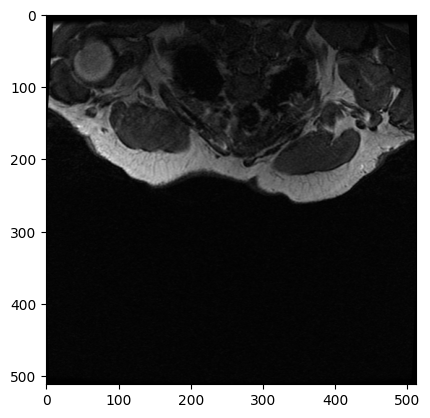

In [34]:
# Ejemplo de las imagenes que estamos usando
# Carga la imagen DICOM
image = pydicom.dcmread("/content/data/img/1-01.dcm")

# Muestra la imagen
plt.imshow(image.pixel_array, cmap="gray")
plt.show()

## **Paso 3: Exploración de datos**

Podemos iniciar revisando los datos clinicos disponibles

In [35]:
# Visualizar las primeras filas del DataFrame de datos clínicos y otras características
print("Datos Clínicos:")
print(clinical_data.head())

Datos Clínicos:
       Patient ID  Days to MRI (From the Date of Diagnosis)  Manufacturer  \
0  Breast_MRI_001                                         6             2   
1  Breast_MRI_002                                        12             0   
2  Breast_MRI_003                                        10             0   
3  Breast_MRI_004                                        18             0   
4  Breast_MRI_005                                        12             2   

   Manufacturer Model Name  Scan Options  Field Strength (Tesla)  \
0                        0             5                       1   
1                        4             1                       3   
2                        3             2                       3   
3                        4             1                       1   
4                        0             5                       1   

   Patient Position During MRI        Image Position of Patient  \
0                            0  -191.8003 X -

In [36]:
# Visualizar las primeras filas del DataFrame de características de las imágenes
print("\nCaracterísticas de las Imágenes:")
print(imaging_features.head())


Características de las Imágenes:
       Patient ID  F1_DT_POSTCON (T11=0.05,T12=0.5)  \
0  Breast_MRI_001                          1.000000   
1  Breast_MRI_002                          1.000000   
2  Breast_MRI_003                          0.174775   
3  Breast_MRI_004                          0.086546   
4  Breast_MRI_005                          0.289669   

   F1_DT_POSTCON (T11=0.05,T12=0.1)  F1_DT_POSTCON (T11=0.02,T12=0.5)  \
0                          0.120721                          0.530395   
1                          0.129546                          0.485217   
2                          0.062051                          0.069910   
3                          0.045111                          0.034619   
4                          0.052031                          0.115868   

   F1_DT_POSTCON (T11=0.02,T12=0.8)  F1_DT_POSTCON (T11=0.05,T12=0.8)  \
0                          1.000000                          1.000000   
1                          1.000000               

Verificamos dentro del dataframe la presencia o ausencia de datos nulos

In [37]:
# Verificar si hay valores nulos en los datos clínicos y otras características
print("\nValores nulos en datos clínicos:")
print(clinical_data.isnull().sum())


Valores nulos en datos clínicos:
Patient ID                                                                                            0
Days to MRI (From the Date of Diagnosis)                                                              0
Manufacturer                                                                                          0
Manufacturer Model Name                                                                               0
Scan Options                                                                                          0
                                                                                                   ... 
Pathologic response to Neoadjuvant therapy:  Pathologic stage (N) following neoadjuvant therapy     652
Pathologic response to Neoadjuvant therapy:  Pathologic stage (M) following neoadjuvant therapy     657
Overall Near-complete Response:  Stricter Definition                                                610
Overall Near-complete Response

Dentro de la informacion que tenemos de las imagenes, evaluamos mediante una correlacion si existe alguna relacion entre algunas variables

<ipython-input-42-6864973823a2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = imaging_features.corr()


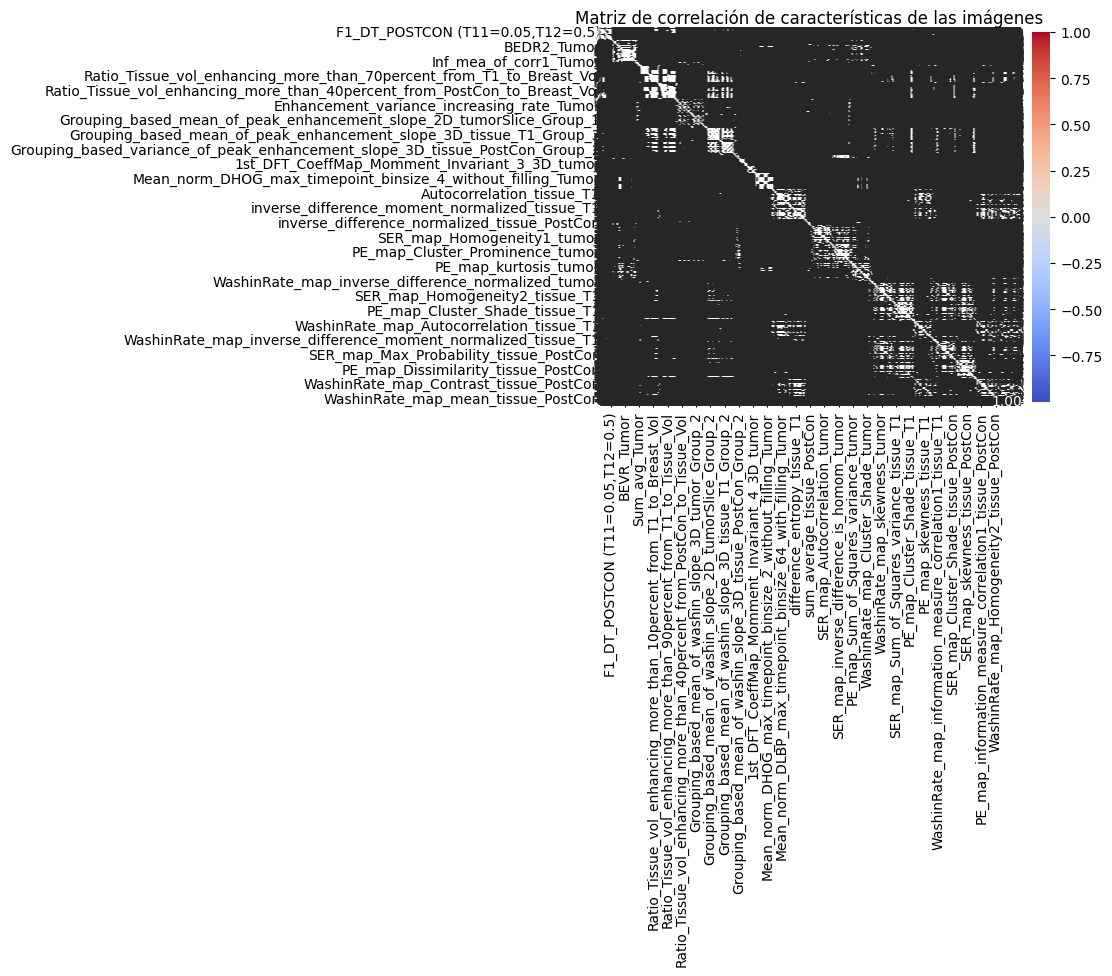

In [42]:
# Visualizar la correlación entre características de las imágenes
correlation_matrix = imaging_features.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación de características de las imágenes')
plt.show()


La matriz de correlación muestra que hay una correlación significativa entre muchas de las características. Por ejemplo, el volumen del tumor está correlacionado positivamente con la tasa de aumento de la intensidad del contraste del tumor. Esto significa que los tumores más grandes tienden a tener una tasa de aumento de la intensidad del contraste más alta.

La matriz de correlación también puedo usarla para identificar características que son útiles para la clasificación de tumores. Por ejemplo, si una característica está fuertemente correlacionada con la presencia de un tumor, entonces esa característica puede usarse para clasificar las imágenes de RM como positivas o negativas para cáncer de mama.

Analizamos las variables clinicas de forma organizada para considerar algunas de interes preliminar

In [84]:
print(clinical_data.columns)

Index(['Patient ID', 'Days to MRI (From the Date of Diagnosis)',
       'Manufacturer', 'Manufacturer Model Name', 'Scan Options',
       'Field Strength (Tesla)', 'Patient Position During MRI',
       'Image Position of Patient', 'Contrast Agent',
       'Contrast Bolus Volume (mL)', 'TR (Repetition Time)', 'TE (Echo Time)',
       'Acquisition Matrix', 'Slice Thickness ', 'Rows', 'Columns',
       'Reconstruction Diameter ', 'Flip Angle \n',
       'FOV Computed (Field of View) in cm ', 'Date of Birth (Days)',
       'Menopause (at diagnosis)', 'Race and Ethnicity',
       'Metastatic at Presentation (Outside of Lymph Nodes)', 'ER', 'PR',
       'HER2', 'Mol Subtype', 'Oncotype score', 'Staging(Tumor Size)# [T]',
       'Staging(Nodes)#(Nx replaced by -1)[N]',
       'Staging(Metastasis)#(Mx -replaced by -1)[M]', 'Tumor Grade',
       'Tumor Grade(N)\n(Nuclear)', 'Tumor Grade(M)\n(Mitotic)',
       'Nottingham grade', 'Histologic type', 'Tumor Location', 'Position',
       'Bilateral

Renombramos la columna 'Date of Birth (Days)' y la convertimos en 'Age'

In [85]:
# Renombrar la columna 'Date of Birth (Days)'
clinical_data.rename(columns={'Date of Birth (Days)': 'Age'}, inplace=True)


Revisamos en que formato y condiciones esta contenida la variable

In [86]:
# Ver los valores únicos en la columna 'Age at last contact...'
unique_values = clinical_data['Age'].unique()

# Mostrar los valores únicos
print(unique_values)


[-15209 -14061 -22685 -21479 -13932 -16735 -16101 -16771 -20541 -24712
 -19389 -15885 -13645 -14031 -23034 -19059 -28866 -29145 -13100 -17377
 -15855 -19510 -13604 -22015 -15542 -23239 -16894 -15304 -23430 -20514
 -22843 -17849 -22767 -17710 -19085 -20332 -22311 -23459 -16012 -17606
 -24543 -29457 -16967 -12766 -16640 -19684 -21687 -14801 -18372 -21169
 -14122 -19927 -16790 -15315 -26760 -19253 -25824 -24782 -18635 -17314
 -21677 -18444  -9907 -20106 -25796 -25088 -21051 -18808 -16870 -16888
 -13044 -19509 -14700 -16834 -23235 -19188 -14100 -12459 -19467 -24660
 -19284 -10690 -19434 -22118 -13474 -13340 -19368 -15579 -24506 -22051
 -23797 -17154 -21940 -18266 -17327 -12384 -20661 -18284 -25234 -16367
 -16730 -19836 -18701 -26204 -10933 -20593 -23726 -21858 -27008 -21475
 -17240 -24182 -21998 -18028 -13475 -16546 -11842 -15477 -20588 -17007
 -17424 -15153 -22829 -25459 -17683 -20296 -14635 -18878 -23237 -18791
 -19274 -16285 -13372 -19070 -15633 -19906 -19971 -24835 -21279 -23437
 -1794

Como los datos estan en dias transcurridos de vida, los transformamos a años.

In [87]:
# Convertir los valores de días a años en la columna 'Age'
# Dividir por 365.25 y tomar el valor absoluto
clinical_data['Age'] = abs(clinical_data['Age'] / 365.25)


In [ ]:
Una vez transformados en años, verificamos que esten correctamente transformados.

In [88]:
# Ver los valores únicos en la columna 'Age at last contact...'
unique_values = clinical_data['Age'].unique()

# Mostrar los valores únicos
print(unique_values)


[41.63997262 38.49691992 62.10814511 58.80629706 38.14373717 45.81793292
 44.08213552 45.91649555 56.23819302 67.65776865 53.08418891 43.49075975
 37.35797399 38.41478439 63.06365503 52.18069815 79.03080082 79.79466119
 35.86584531 47.57563313 43.40862423 53.41546886 37.24572211 60.27378508
 42.55167693 63.62491444 46.2532512  41.90006845 64.14784394 56.16427105
 62.54072553 48.8678987  62.33264887 48.48733744 52.25188227 55.6659822
 61.08418891 64.22724162 43.8384668  48.20260096 67.19507187 80.64887064
 46.45311431 34.95140315 45.5578371  53.89185489 59.37577002 40.5229295
 50.29979466 57.95756331 38.66392882 54.55715264 45.96851472 41.9301848
 73.26488706 52.7118412  70.70225873 67.84941821 51.01984942 47.40314853
 59.34839151 50.49691992 27.12388775 55.04722793 70.6255989  68.68720055
 57.63449692 51.4934976  46.18754278 46.23682409 35.71252567 53.41273101
 40.24640657 46.08898015 63.61396304 52.5338809  38.6036961  34.11088296
 53.29774127 67.51540041 52.79671458 29.26762491 53.20

verificamos que esten las entradas completas, 922. se valido que no hubiera datos faltantes o NaN y no se encontraron, por lo que no se muestra codigo aqui.

In [89]:
clinical_data['Age']

0      41.639973
1      38.496920
2      62.108145
3      58.806297
4      38.143737
         ...    
917    66.209446
918    75.775496
919    62.401095
920    40.750171
921    57.368925
Name: Age, Length: 922, dtype: float64

In [ ]:
Ahora, analizamos como se distribuye la edad de los casos, y los subtipos moleculares de la enfermedad se distribuyen en los casos segun la edad.

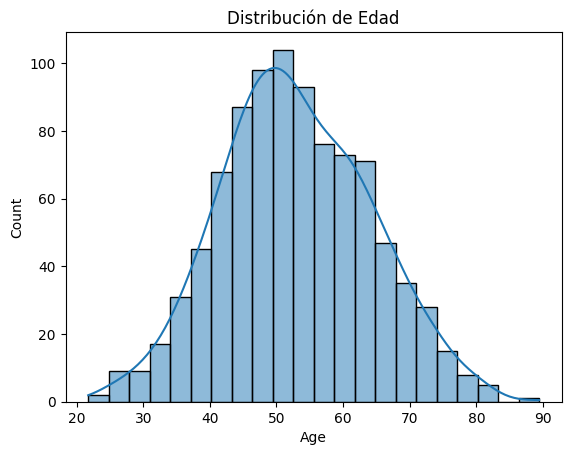

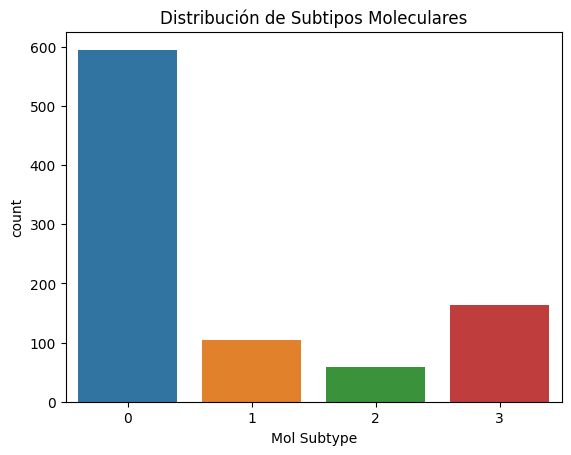

In [91]:
# Análisis descriptivo de los datos clínicos
clinical_data.describe()

# Visualizar distribución de variables clave en los datos clínicos
sns.histplot(clinical_data['Age'], kde=True)
plt.title('Distribución de Edad')
plt.show()

sns.countplot(x='Mol Subtype', data=clinical_data)
plt.title('Distribución de Subtipos Moleculares')
plt.show()



El gráfico muestra que el subtipo luminal-like es el más común, seguido del subtipo HER2. El subtipo triple negativo es el menos común.

El subtipo luminal-like se caracteriza por la expresión de receptores de estrógeno (ER) y progesterona (PR), pero no de HER2. Este subtipo es generalmente más sensible a la terapia hormonal que otros subtipos.

El subtipo HER2 se caracteriza por la expresión de HER2. Este subtipo es generalmente más sensible a la terapia dirigida con anticuerpos monoclonales contra HER2.

El subtipo triple negativo no expresa ER, PR ni HER2. Este subtipo es generalmente más resistente a la terapia hormonal y dirigida.

El gráfico también muestra que la distribución de los subtipos moleculares varía según la edad. Los subtipos luminal-like y triple negativo son más comunes en pacientes más jóvenes, mientras que el subtipo HER2 es más común en pacientes mayores.

Estas diferencias en la distribución de los subtipos moleculares pueden deberse a factores genéticos, hormonales o ambientales.

Se requiere seguir ampliando el notebook y el desarrollo y tratamiento de los datos para tener un buen dataset de inicio y poder correlacionar de forma adecuada con las imagenes que son los pasos posteriores a definir y establecer las variables clinicas de mayor interes.